In [1]:
import yfinance as yf
import pandas as pd

# 选定股票和市场指数
stock_tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "JPM", "V", "PG", "DIS"]
market_ticker = "^GSPC"

# 下载数据
start_date = "2019-01-01"
end_date = "2024-01-01"
data = yf.download(stock_tickers + [market_ticker], start=start_date, end=end_date)

# 提取收盘价
adj_close_data = data["Close"]

# **确保数据为数值类型**
adj_close_data = adj_close_data.apply(pd.to_numeric, errors='coerce')

# **修复 `pct_change()` 计算 NaN 问题**
returns = adj_close_data.pct_change().ffill().dropna()

# **保存 CSV**
adj_close_data.to_csv("result/adj_close_data.csv")   # 保存原始收盘价数据
returns.to_csv("result/returns_data.csv")            # 保存每日收益率数据

# **打印前 5 行，确认数据结构**
print("Adjusted Close Data:")
print(adj_close_data.head())

print("\nReturns Data:")
print(returns.head())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  11 of 11 completed


Adjusted Close Data:
Ticker           AAPL       AMZN         DIS      GOOGL        JPM       MSFT  \
Date                                                                            
2019-01-02  37.667179  76.956497  106.340645  52.483086  82.916237  95.119827   
2019-01-03  33.915268  75.014000  103.764343  51.029530  81.737823  91.620552   
2019-01-04  35.363075  78.769501  106.965202  53.647015  84.751129  95.881752   
2019-01-07  35.284355  81.475502  107.892281  53.540031  84.810059  96.004036   
2019-01-08  35.956989  82.829002  108.731522  54.010277  84.650139  96.700142   

Ticker          NVDA         PG       TSLA           V        ^GSPC  
Date                                                                 
2019-01-02  3.377779  77.998970  20.674667  127.274887  2510.030029  
2019-01-03  3.173705  77.452057  20.024000  122.688347  2447.889893  
2019-01-04  3.377035  79.032913  21.179333  127.973900  2531.939941  
2019-01-07  3.555818  78.716736  22.330667  130.281555  2549.

In [2]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

# **读取 CSV，确保数据格式正确**
returns = pd.read_csv("result/returns_data.csv")

# **去除列名空格**
returns.columns = returns.columns.str.strip()

# **转换日期格式**
returns.rename(columns={"Date": "date"}, inplace=True)  # 确保日期列正确
returns["date"] = pd.to_datetime(returns["date"])  # 转换日期格式

# **设置索引为日期**
returns.set_index("date", inplace=True)

# **转换所有数据为数值类型，防止 OLS 报错**
returns = returns.apply(pd.to_numeric, errors='coerce')

# **去除 NaN 值**
returns.dropna(inplace=True)

# **定义无风险收益率（Rf）**
Rf = 0.02  # 5%

# **分离市场收益率和个股收益率**
market_ticker = "^GSPC"  # S&P 500 作为市场指数
market_returns = returns[market_ticker]  # 市场收益率
stock_returns = returns.drop(columns=[market_ticker])  # 个股收益率

# **存储 CAPM 计算结果**
beta_values = {}
alpha_values = {}
idiosyncratic_variance = {}

# **对每只股票进行 CAPM 计算**
for stock in stock_returns.columns:
    Y = stock_returns[stock] - Rf  # **计算超额收益** Ri - Rf
    X = market_returns - Rf  # **市场超额收益** Rm - Rf

    # **确保数据为数值类型**
    Y = pd.to_numeric(Y, errors='coerce')
    X = pd.to_numeric(X, errors='coerce')

    # **去除 NaN/无效数据**
    valid_idx = Y.notna() & X.notna()
    Y = Y[valid_idx]
    X = X[valid_idx]

    # **转换为 NumPy 数组，防止 statsmodels 误判数据类型**
    Y = np.asarray(Y, dtype=np.float64)
    X = np.asarray(X, dtype=np.float64)

    # **添加常数项 α**
    X = sm.add_constant(X)

    # **执行回归**
    model = sm.OLS(Y, X).fit()
    alpha, beta = model.params  # 获取 α 和 β
    residuals = model.resid  # 获取 ϵi

    # **计算个体风险（idiosyncratic variance）**
    idiosyncratic_variance[stock] = np.var(residuals)

    # **存储 α 和 β**
    alpha_values[stock] = alpha
    beta_values[stock] = beta

# **计算市场平均收益**
market_mean_return = market_returns.mean()

# **计算每只股票的预期收益**
expected_returns = {stock: Rf + beta * (market_mean_return - Rf) for stock, beta in beta_values.items()}

# **保存 CAPM 计算结果到 CSV**
results_df = pd.DataFrame({
    "Beta": beta_values,
    "Expected Return": expected_returns,
    "Idiosyncratic Variance": idiosyncratic_variance
})

results_df.to_csv("result/capm_results.csv")  # 保存结果

# **打印 CAPM 计算结果**
print("CAPM 计算完成，结果已保存到 result/capm_results.csv")
print(results_df)

CAPM 计算完成，结果已保存到 result/capm_results.csv
           Beta  Expected Return  Idiosyncratic Variance
AAPL   1.215625        -0.003581                0.000146
AMZN   1.065801        -0.000675                0.000287
DIS    1.051246        -0.000393                0.000246
GOOGL  1.135638        -0.002030                0.000169
JPM    1.098643        -0.001312                0.000186
MSFT   1.182136        -0.002932                0.000117
NVDA   1.728839        -0.013537                0.000524
PG     0.584797         0.008656                0.000116
TSLA   1.503262        -0.009161                0.001252
V      1.048806        -0.000345                0.000113


In [3]:
import numpy as np
import pandas as pd
from cvxopt import matrix, solvers

# **读取 CAPM 计算结果**
capm_results = pd.read_csv("result/capm_results.csv", index_col=0)

# **读取市场收益率**
market_returns = pd.read_csv("result/returns_data.csv", index_col=0)["^GSPC"]

# **转换 Beta, 期望收益, 个体风险 为字典**
beta_values = capm_results["Beta"].to_dict()
expected_returns = capm_results["Expected Return"].to_dict()
idiosyncratic_variance = capm_results["Idiosyncratic Variance"].to_dict()

# **计算市场收益率的方差**
market_variance = np.var(market_returns.astype(np.float64))

# **获取股票列表**
stock_list = list(beta_values.keys())
num_assets = len(stock_list)

# **计算协方差矩阵 Σ**
covariance_matrix = np.zeros((num_assets, num_assets))

for i in range(num_assets):
    for j in range(num_assets):
        if i == j:
            covariance_matrix[i, j] = (
                    beta_values[stock_list[i]] ** 2 * market_variance
                    + idiosyncratic_variance[stock_list[i]]
            )
        else:
            covariance_matrix[i, j] = (
                    beta_values[stock_list[i]] * beta_values[stock_list[j]] * market_variance
            )

# **转换为 QP 格式**
P = matrix(covariance_matrix, tc="d")  # 目标函数的二次项
q = matrix(np.zeros(num_assets), tc="d")  # 目标函数的一次项（最小化方差）

# **目标收益率 μp**
target_returns = [0.08, 0.12, 0.15]  # 预设的目标收益率

# **存储最优权重**
optimal_weights = {}

# **计算不同目标收益率的最优投资组合**
for mu_p in target_returns:
    # **构造约束矩阵**
    G = matrix(-np.identity(num_assets), tc="d")  # 约束 w ≥ 0
    h = matrix(np.zeros(num_assets), tc="d")  # 权重非负

    # **构造等式约束**
    A_matrix = np.vstack(
        (
            np.ones(num_assets),  # 第一行全1，确保权重之和为1
            np.array([expected_returns[stock] for stock in stock_list], dtype=np.float64),
        )
    )
    A = matrix(A_matrix, tc="d")
    b = matrix(np.array([1.0, mu_p], dtype=np.float64).reshape((2, 1)), tc="d")  # `b` 必须是 2×1 列向量

    # **求解 QP 问题**
    sol = solvers.qp(P, q, G, h, A, b)
    weights = np.array(sol["x"]).flatten()

    # **存储结果**
    optimal_weights[mu_p] = weights
    print(f"Optimal Weights for μp={mu_p}: {weights}")

# **将结果存入 DataFrame 并保存到 CSV**
optimal_weights_df = pd.DataFrame(optimal_weights, index=stock_list)
optimal_weights_df.to_csv("result/optimal_portfolio_weights.csv")

print("\nOptimal Portfolio Weights saved to 'result/optimal_portfolio_weights.csv'")


     pcost       dcost       gap    pres   dres
 0:  5.5216e-03  1.8245e+01  1e+02  1e+01  1e+01
 1:  4.1162e-03  3.4085e+01  4e+00  2e+00  2e+00
 2:  4.1174e-03  4.2981e+02  4e+00  2e+00  2e+00
 3:  4.1136e-03  5.0493e+04  4e+01  2e+00  2e+00
 4:  4.1130e-03  5.9829e+07  1e+03  2e+00  2e+00
 5:  4.1131e-03  3.8582e+10  6e+03  2e+00  2e+00
Terminated (singular KKT matrix).
Optimal Weights for μp=0.08: [-0.63776617 -0.63776622 -0.63776622 -0.6377662  -0.63776621 -0.63776619
 -0.63776595  6.73984101 -0.63776596 -0.63776622]
     pcost       dcost       gap    pres   dres
 0:  1.2867e-02  4.3593e+01  2e+02  2e+01  2e+01
 1:  9.6409e-03  7.5535e+01  9e+00  3e+00  4e+00
 2:  9.6540e-03  9.1395e+02  8e+00  3e+00  3e+00
 3:  9.6486e-03  1.1069e+05  9e+01  3e+00  3e+00
 4:  9.6476e-03  1.3467e+08  2e+03  3e+00  3e+00
 5:  9.6478e-03  7.1986e+10  1e+04  3e+00  3e+00
Terminated (singular KKT matrix).
Optimal Weights for μp=0.12: [-0.99533726 -0.99533735 -0.99533735 -0.99533733 -0.99533734 -0.995

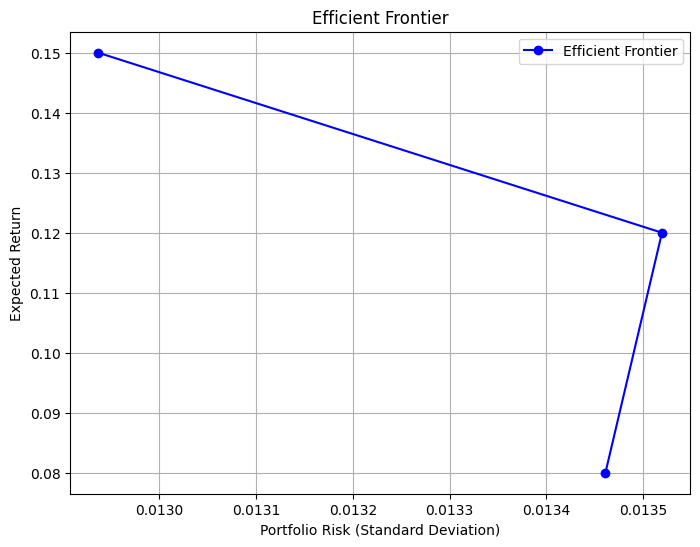

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# **读取权重数据**
optimal_weights_df = pd.read_csv("result/optimal_portfolio_weights.csv", index_col=0)

# **目标收益率 μp**
target_returns = [0.08, 0.12, 0.15]

# **读取 CAPM 计算时的协方差矩阵**
capm_results = pd.read_csv("result/capm_results.csv", index_col=0)
market_returns = pd.read_csv("result/returns_data.csv", index_col=0)["^GSPC"]

# **计算市场收益率的方差**
market_variance = np.var(market_returns.astype(np.float64))

# **获取股票列表**
stock_list = list(capm_results.index)
num_assets = len(stock_list)

# **转换 Beta, 期望收益, 个体风险 为字典**
beta_values = capm_results["Beta"].to_dict()
idiosyncratic_variance = capm_results["Idiosyncratic Variance"].to_dict()

# **重新计算协方差矩阵 Σ**
covariance_matrix = np.zeros((num_assets, num_assets))

for i in range(num_assets):
    for j in range(num_assets):
        if i == j:
            covariance_matrix[i, j] = (
                beta_values[stock_list[i]] ** 2 * market_variance
                + idiosyncratic_variance[stock_list[i]]
            )
        else:
            covariance_matrix[i, j] = (
                beta_values[stock_list[i]] * beta_values[stock_list[j]] * market_variance
            )

# **计算风险**
risks = []

for mu_p in target_returns:
    weights = optimal_weights_df[str(mu_p)].values  # 读取对应目标收益率的权重

    # **确保权重合理化**
    weights = np.abs(weights)  # 取绝对值，防止负权重
    weights /= np.sum(weights)  # 归一化，确保总和为 1

    # **计算组合方差**
    portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))
    portfolio_std = np.sqrt(portfolio_variance)  # 计算标准差（风险）
    risks.append(portfolio_std)




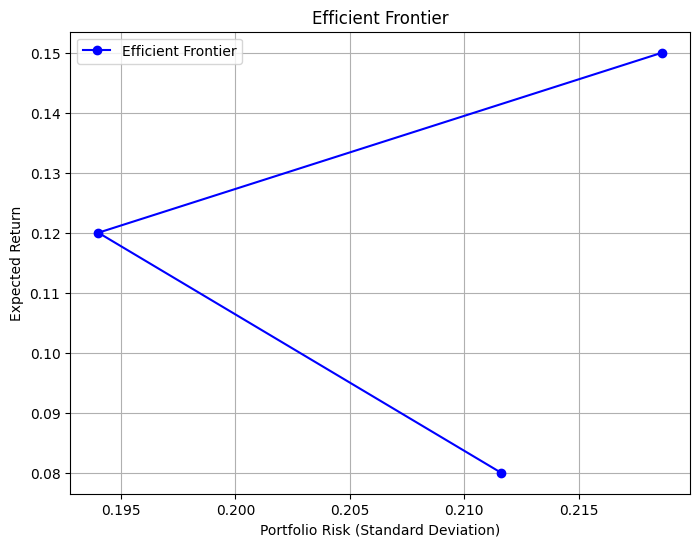

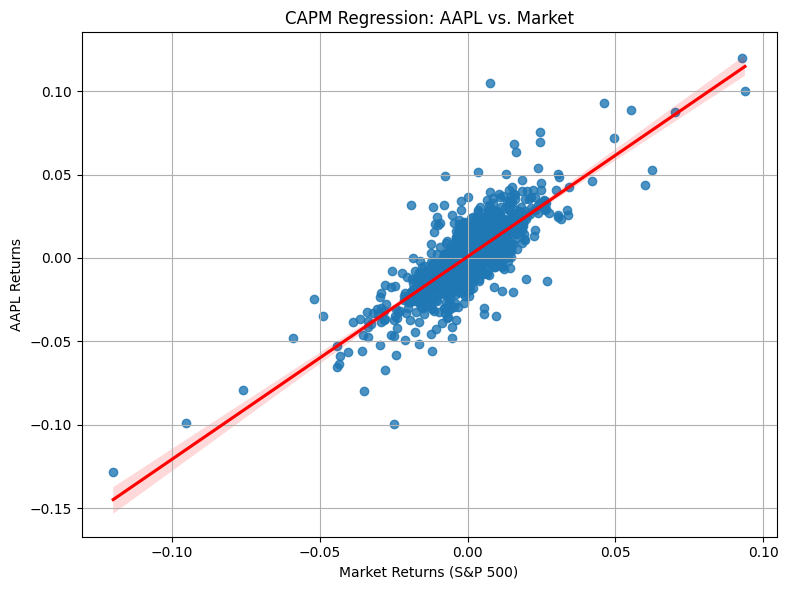

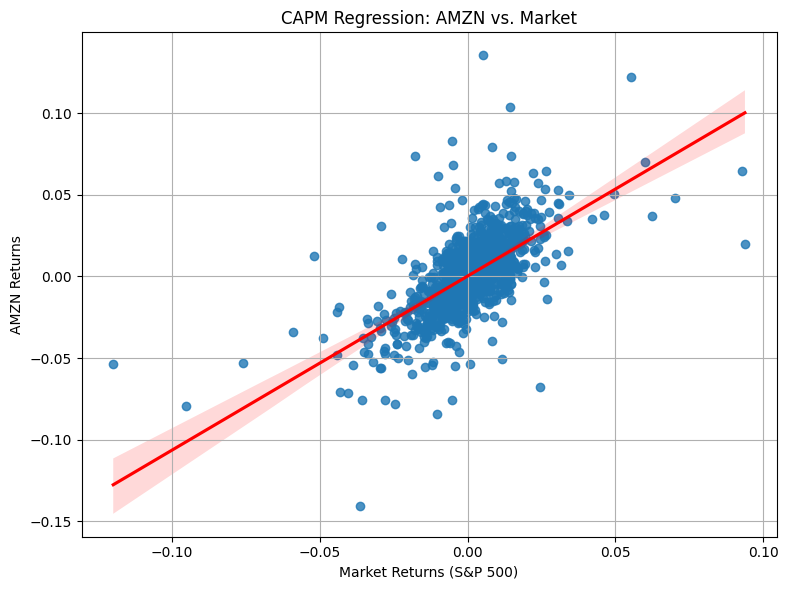

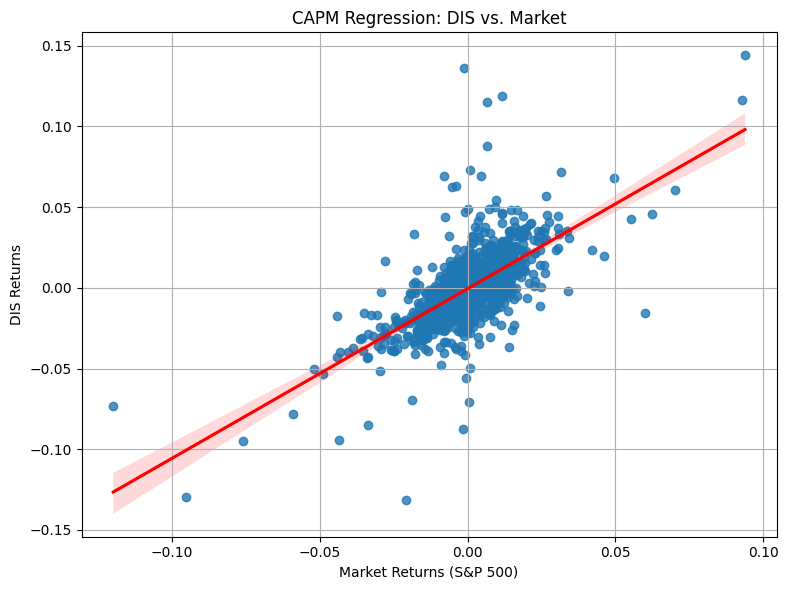

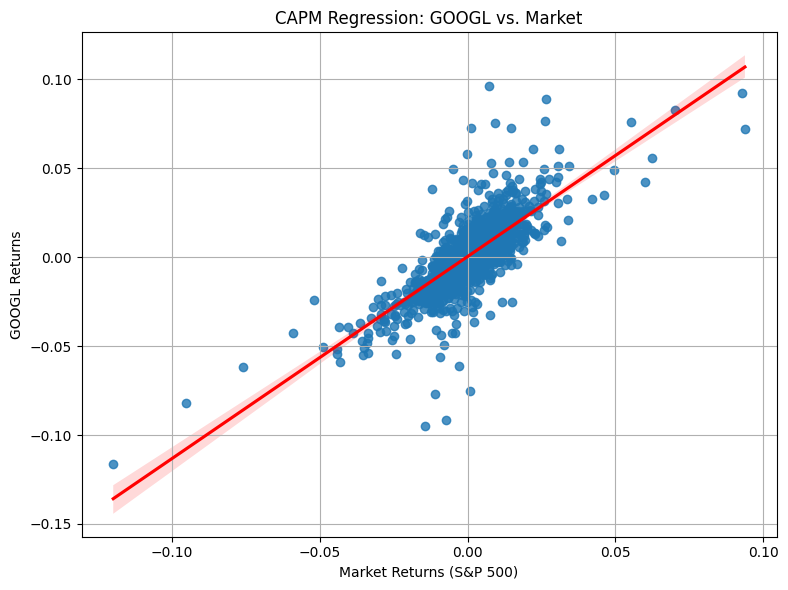

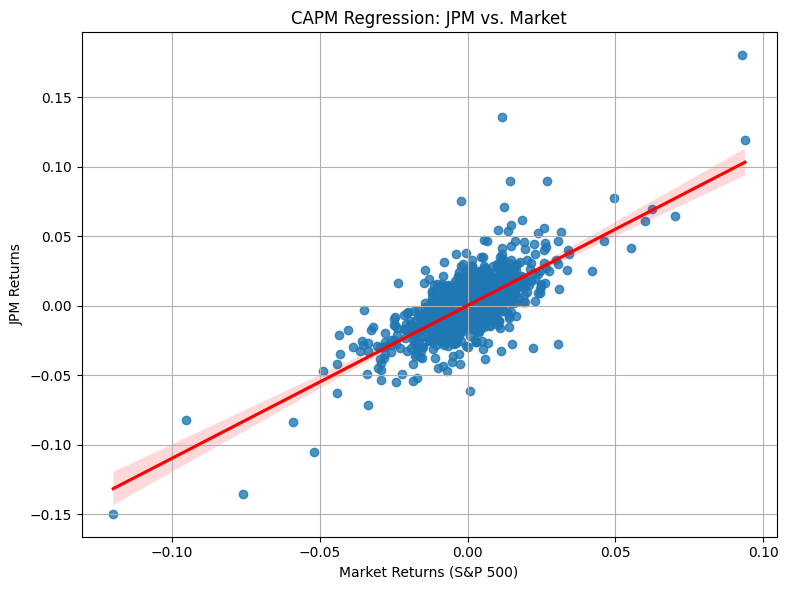

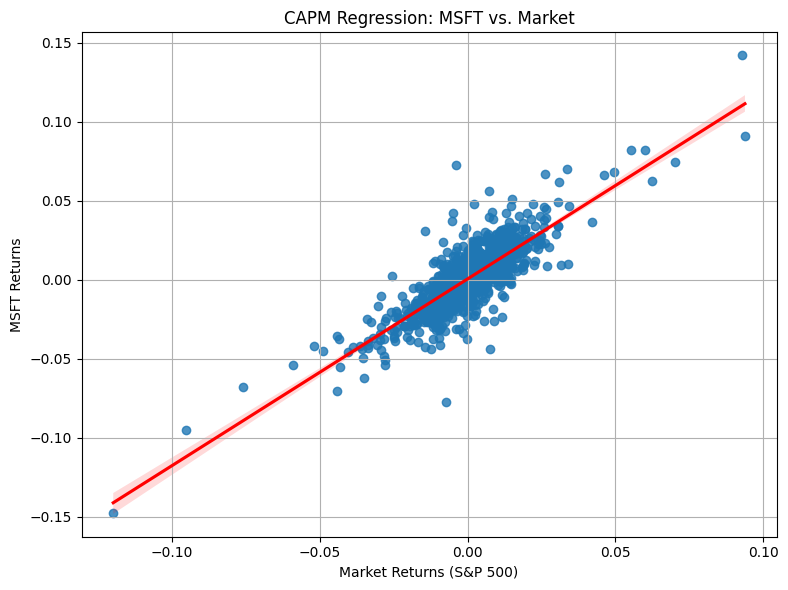

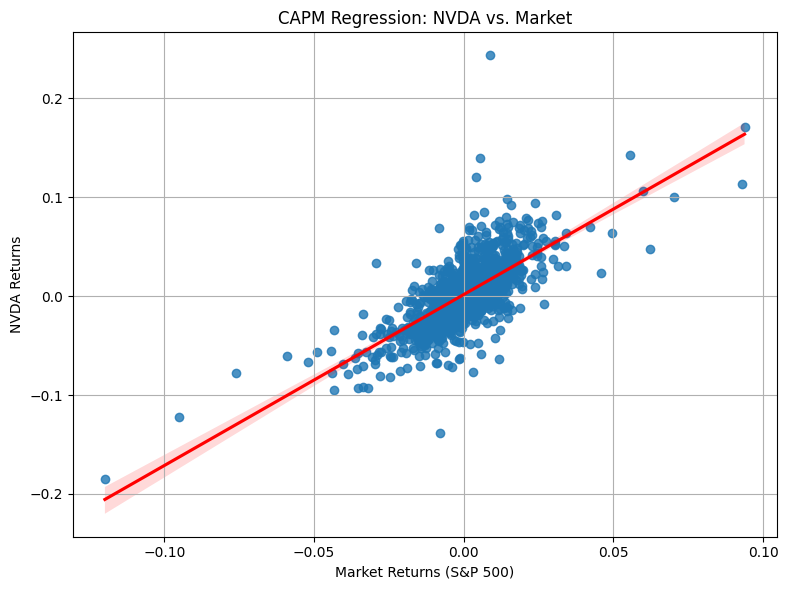

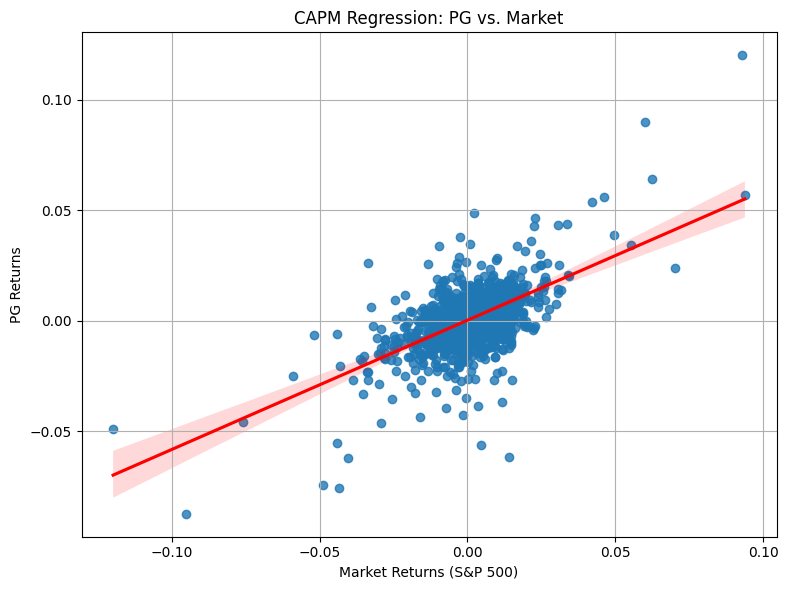

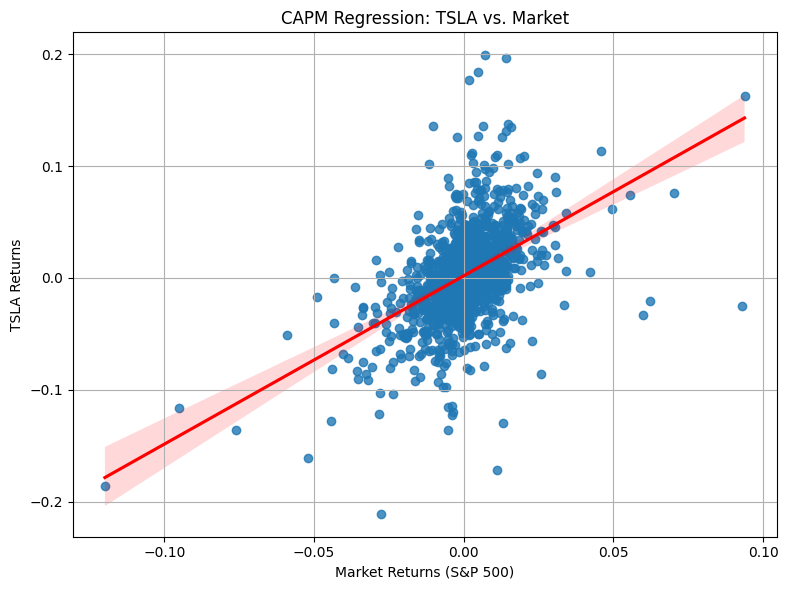

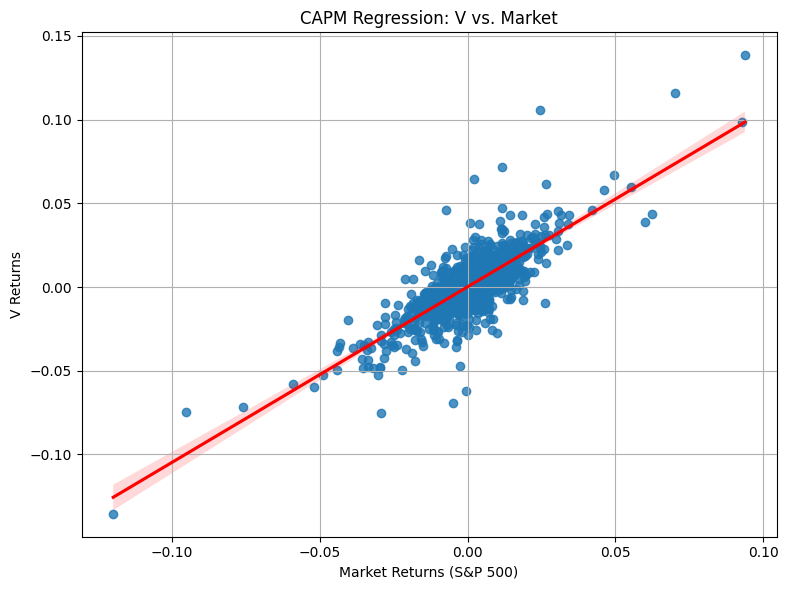

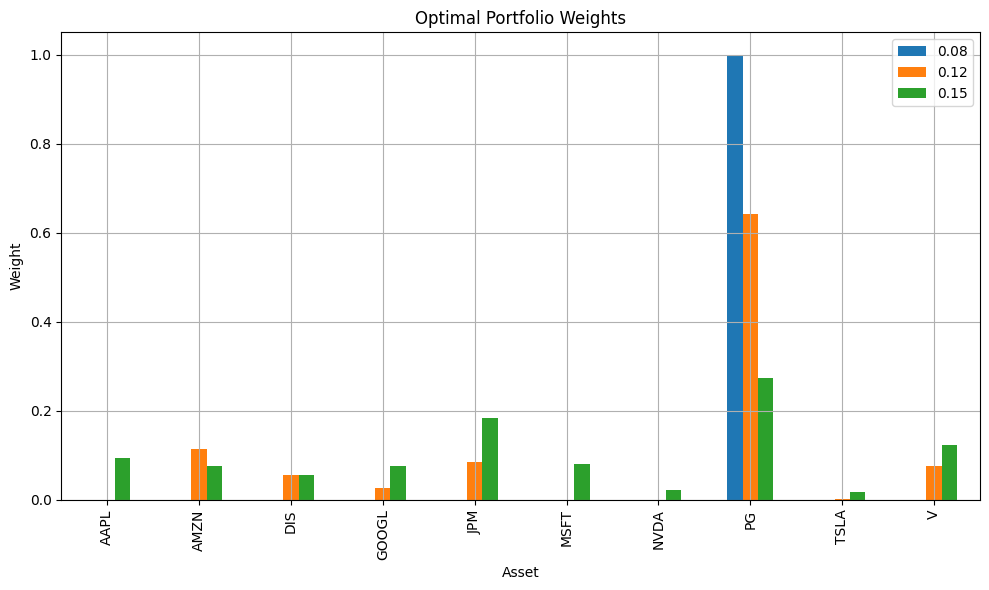

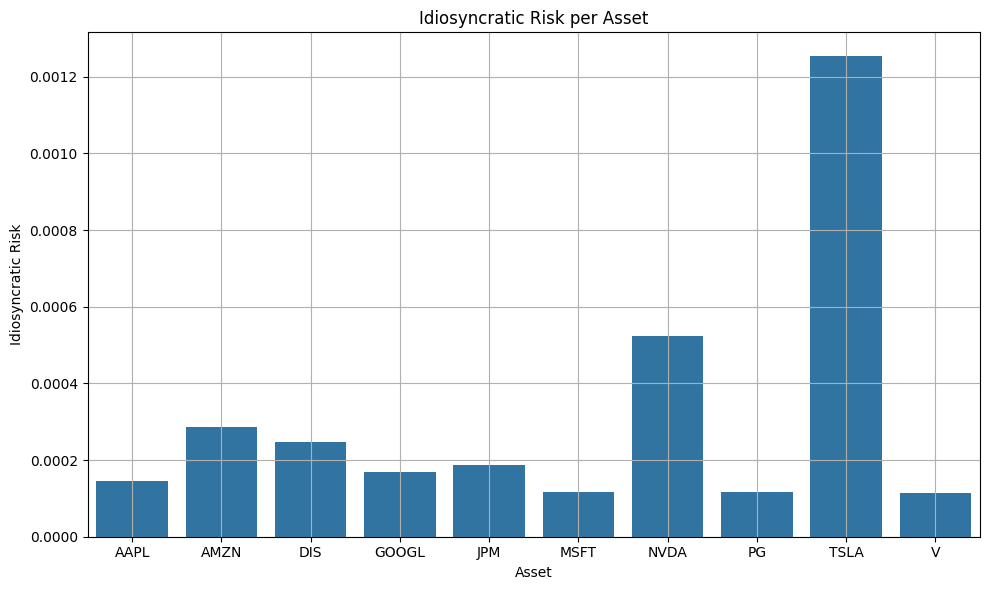

所有图表已保存至 report 文件夹。


In [5]:
# 由于执行状态已重置，需要重新导入所有必要的库

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.optimize import minimize

# 重新加载数据文件
adj_close_path = "result/adj_close_data.csv"
returns_path = "result/returns_data.csv"

adj_close_data = pd.read_csv(adj_close_path, index_col=0, parse_dates=True)
returns_data = pd.read_csv(returns_path, index_col=0, parse_dates=True)

# 确保 report 目录存在
report_folder = "report"
os.makedirs(report_folder, exist_ok=True)

# 设置无风险收益率
Rf = 0.02 / 252  # 转换为每日利率

# 提取市场收益（S&P 500）
Rm = returns_data['^GSPC']

# 提取资产列表（去除市场指数）
assets = returns_data.drop(columns=['^GSPC']).columns

# CAPM 回归分析：计算 alpha、beta 和特异风险（idiosyncratic risk）
capm_results = []
for asset in assets:
    Y = returns_data[asset] - Rf
    X = sm.add_constant(Rm - Rf)
    model = sm.OLS(Y, X).fit()
    alpha, beta = model.params
    residual_var = np.var(model.resid, ddof=1)  # 计算特异风险
    capm_results.append([asset, beta, alpha, residual_var])

# 生成 CAPM 结果表格
capm_results_df = pd.DataFrame(capm_results, columns=['Asset', 'Beta', 'Alpha', 'Idiosyncratic Risk'])

# 计算协方差矩阵
cov_matrix = returns_data[assets].cov() * 252

# 计算市场风险溢价
market_premium = Rm.mean() * 252 - 0.02

# 计算资产的期望收益率（基于 CAPM）
expected_returns = Rf * 252 + capm_results_df['Beta'] * market_premium

# 定义二次优化函数（最小化组合波动率）
def portfolio_optimization(target_return, returns, cov_matrix):
    num_assets = len(returns)

    def portfolio_volatility(weights, cov_matrix):
        return np.sqrt(weights.T @ cov_matrix @ weights)

    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: np.sum(x * returns) - target_return}
    )

    bounds = tuple((0, 1) for _ in range(num_assets))
    result = minimize(portfolio_volatility, num_assets * [1./num_assets], args=(cov_matrix,),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# 针对不同目标收益计算最优权重
target_returns = [0.08, 0.12, 0.15]
optimal_weights = {}
for tr in target_returns:
    weights = portfolio_optimization(tr, expected_returns, cov_matrix)
    optimal_weights[tr] = weights

optimal_weights_df = pd.DataFrame(optimal_weights, index=assets)

# 计算投资组合的风险（标准差）
portfolio_risks = [np.sqrt(w.T @ cov_matrix @ w) for w in optimal_weights.values()]

# 生成并保存所有图表

# 1. 有效前沿图
plt.figure(figsize=(8, 6))
plt.plot(portfolio_risks, target_returns, marker="o", linestyle="-", color="b", label="Efficient Frontier")
plt.xlabel("Portfolio Risk (Standard Deviation)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(report_folder, "efficient_frontier.png"), dpi=300, bbox_inches="tight")
plt.show()

# 2. CAPM 回归分析图
for asset in assets:
    plt.figure(figsize=(8, 6))
    sns.regplot(x=Rm, y=returns_data[asset], line_kws={'color': 'red'})
    plt.title(f'CAPM Regression: {asset} vs. Market')
    plt.xlabel('Market Returns (S&P 500)')
    plt.ylabel(f'{asset} Returns')
    plt.grid(True)
    plt.tight_layout()
    filename = f"capm_regression_{asset}.png"
    plt.savefig(os.path.join(report_folder, filename), dpi=300, bbox_inches="tight")
    plt.show()

# 3. 投资组合权重可视化
optimal_weights_df.plot(kind='bar', figsize=(10, 6))
plt.title('Optimal Portfolio Weights')
plt.ylabel('Weight')
plt.xlabel('Asset')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(report_folder, "optimal_portfolio_weights.png"), dpi=300, bbox_inches="tight")
plt.show()

# 4. 特异风险（Idiosyncratic Risk）柱状图
plt.figure(figsize=(10, 6))
sns.barplot(x='Asset', y='Idiosyncratic Risk', data=capm_results_df)
plt.title('Idiosyncratic Risk per Asset')
plt.ylabel('Idiosyncratic Risk')
plt.xlabel('Asset')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(report_folder, "idiosyncratic_risk.png"), dpi=300, bbox_inches="tight")
plt.show()

# 最终确认信息
print(f"所有图表已保存至 {report_folder} 文件夹。")
